In [6]:
import sys
import os
from netCDF4 import Dataset
import matplotlib.pylab as plt
import numpy as np
from sklearn import tree
from matplotlib.colors import LogNorm
from sklearn import ensemble
from IPython.core.display import display, HTML
import math

display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
!tree ..

..
├── Data
│   ├── cl_l.nc
│   ├── ncr_pdf_douze_00625deg.nc
│   ├── ncr_pdf_douze_0125deg.nc
│   ├── ncr_pdf_douze_025deg.nc
│   ├── ncr_pdf_douze_05deg.nc
│   └── ncr_pdf_douze_1deg.nc
├── MSC_repo
│   ├── NetCDF_viewer.ipynb
│   ├── requirements.txt
│   ├── tree_test.ipynb
│   └── tree_test_original.ipynb
└── Philip_2018_script
    ├── domain_cutter.py
    ├── join_script.sh
    ├── plot_3pdfs_hist_cf.py
    ├── plot_8_2dhist_ECMWF.py
    ├── plot_cloud_analysis_ncr.py
    ├── plot_paper_T_q_scat.py
    ├── proc_loop_HDCP.sh
    ├── README_on_douze_files.txt
    ├── README_plotscripts.txt
    ├── README_proc_ncl_sh_scrips.txt
    └── ridderfunca.ncl

3 directories, 21 files


In [4]:
%pwd ../..

'/home/igor/UNI/Master Project/Script/MSC_repo'

In [7]:
file_dir = '/home/igor/UNI/Master Project/Script/Data/'

In [8]:
os.listdir(file_dir)

['ncr_pdf_douze_05deg.nc',
 'cl_l.nc',
 'ncr_pdf_douze_1deg.nc',
 'ncr_pdf_douze_0125deg.nc',
 'ncr_pdf_douze_025deg.nc',
 'ncr_pdf_douze_00625deg.nc']

# TODO

1. Apply a tree trained for one resolution to another
2. Check gradient boost and random forest across resolutions

# Showing tree and max_depth dependency

In [9]:
def func_plot_cfhist(dat_string,goal_var,input_var,train_fraction=0.6,rel_flag=0,max_depth_in=None):
    #Applies a decisiontreeregressor returns a 2d hist plots 
    #rel_flag: Since relative humidity is not part of the douze data it is calculated here and added according to this flat
    #rel_flag = 1, adds rel_hum
    #rel_flag = 2, adds qvlm_sqsm (qt-sat)
    
    #Loading data
    data= Dataset(dat_string)
    y = data.variables[goal_var][:].ravel()
    
    for input in input_var:
        x_temp = data.variables[input][:].ravel()
        if input==input_var[0]:
            X = x_temp
        else:
            X = np.vstack([X,x_temp])
    
    input_var_tmp = input_var.copy()
    #print(input_var_tmp)

    
    #Add relative humidity
    if rel_flag==1:
        rel_sat =  data.variables['qvlm'][:].ravel()/ data.variables['qsm'][:].ravel()
        X = np.vstack([X,rel_sat])
        input_var_tmp.append('rel_sat')
    if rel_flag==2:
        qvl_qs =  data.variables['qvlm'][:].ravel()- data.variables['qsm'][:].ravel()
        X = np.vstack([X,qvl_qs])
        input_var_tmp.append('qvl_qs')
        
    #print(input_var_tmp)
        
    n_e = int(len(y)*train_fraction)
    
    p = np.random.permutation(len(y))

    y_shuf = y[p]
    X_shuf = X[:,p]

    y_train =y[n_e:]
    y_eval  =y[:n_e]

    X_train =X[:,n_e:]
    X_eval  =X[:,:n_e]

    X_train = X_train.transpose()
    X_eval = X_eval.transpose()
        
    
    #Now we set up and train the decision tree regressor
    #regr_1 = tree.DecisionTreeRegressor(max_depth=None)
    regr_1 = tree.DecisionTreeRegressor(max_depth=max_depth_in)
    #regr_1 = tree.DecisionTreeRegressor(max_depth=5)
    regr_1.fit(X_train, y_train)
    
    #Now the prediction magic happens
    y_pred = regr_1.predict(X_eval)

    fig = plt.figure(figsize=(10,10))
    bla = plt.hist2d(y_eval,y_pred,bins=100, norm=LogNorm())
    #bla = plt.hist2d(rel_sat,cl_l,bins=100, norm=LogNorm())
    #bla = plt.plot(sat_x,sat_ave,color='w',linewidth=2)
    #plt.vlines(1,0,1,'k')

    
    
    return fig

In [10]:
def round_down(n):
    order = np.floor(math.log(n,10))
    scaled_n = n*10.**(-order)
    floor_scaled = np.floor(scaled_n)
    
    return floor_scaled*10**order

def round_up(n):
    order = np.ceil(math.log(n,10))
    scaled_n = n*10.**(-order)
    floor_scaled = np.ceil(scaled_n)
    
    return floor_scaled*10**order

In [11]:
def func_plot_cfhist_mult(dat_string,goal_var,input_var,train_fraction=0.6,rel_flag=0,max_depth_in_vec=[7,14,0],N_bin=100,learning_flag=0):
    #Applies a regression tree method and returns 2d hist plots
    #If learning_flag = 0: decisiontreeregressor
    #If learning_flag = 1: GradientBoostingRegressor
    #If learning_flag = 2: RandomForestRegressor
    
    #a max_depth in of 0 is set to None
    #same as func_plot_cfhist but with multiple ones
    #rel_flag: Since relative humidity is not part of the douze data it is calculated here and added according to this flat
    #rel_flag = 1, adds rel_hum
    #rel_flag = 2, adds qvlm_sqsm (qt-sat)
    #N_bin is number of bins
    
    #Didn't manage to limit the colorbar in a good way :(
    #Trying to do this better
    
    #Loading data
    data= Dataset(dat_string)
    y = data.variables[goal_var][:].ravel()
    
    for input in input_var:
        x_temp = data.variables[input][:].ravel()
        if input==input_var[0]:
            X = x_temp
        else:
            X = np.vstack([X,x_temp])
    
    input_var_tmp = input_var.copy()
    #print(input_var_tmp)

    
    #Add relative humidity
    if rel_flag==1:
        rel_sat =  data.variables['qvlm'][:].ravel()/ data.variables['qsm'][:].ravel()
        X = np.vstack([X,rel_sat])
        input_var_tmp.append('rel_sat')
    if rel_flag==2:
        qvl_qs =  data.variables['qvlm'][:].ravel()- data.variables['qsm'][:].ravel()
        X = np.vstack([X,qvl_qs])
        input_var_tmp.append('qvl_qs')
        
    #print(input_var_tmp)
        
    n_e = int(len(y)*train_fraction)
    
    p = np.random.permutation(len(y))

    y_shuf = y[p]
    X_shuf = X[:,p]

    y_train =y[n_e:]
    y_eval  =y[:n_e]

    X_train =X[:,n_e:]
    X_eval  =X[:,:n_e]

    X_train = X_train.transpose()
    X_eval = X_eval.transpose()
        
    #Here we start looping over the max_depth_in_vec 
    #Easiest to just only use the fitting one and save the output vector
    
    y_pred_matrix = np.zeros([len(max_depth_in_vec),len(y_eval)])
    
    hist_max = 0
    #Now we set up and train the  regressor
    for m in range(len(max_depth_in_vec)):
        max_depth_in = max_depth_in_vec[m]
        
        if learning_flag == 0:
            if max_depth_in == 0:
                max_depth_in = None
            regr_1 = tree.DecisionTreeRegressor(max_depth=max_depth_in)
        if learning_flag == 1:
            if max_depth_in == 0:
                max_depth_in = None
            regr_1 = ensemble.GradientBoostingRegressor(max_depth=max_depth_in)
        if learning_flag == 2:
            if max_depth_in == 0:
                regr_1 = ensemble.RandomForestRegressor()
            else:
                regr_1 = ensemble.RandomForestRegressor(n_estimators=max_depth_in,max_leaf_nodes=max_depth_in)

            

        #Training
        regr_1.fit(X_train, y_train)
        
        
        if learning_flag ==0:
            #print number of nodes
            print('number of nodes in tree:',regr_1.tree_.node_count)
            print('number samples in training set:',len(y_train))
        
        

        #Now the prediction magic happens
        y_pred_matrix[m,:] = regr_1.predict(X_eval)
      
    
    fig,axes = plt.subplots(1,len(max_depth_in_vec),figsize=(len(max_depth_in_vec)*3.5,3.5),sharex=True,sharey=True)
    
    
    for m in range(len(max_depth_in_vec)):
        
        bla1,bla2,bla3,bla4 = axes[m].hist2d(y_eval,y_pred_matrix[m,:],bins=N_bin, norm=LogNorm(),range=[[0,1],[0,1]])

        #Here is an abondoned attempt to restrict the top value in a good way. It somehow didn't really work :() 
        if m == 0:
            bla1,bla2,bla3,bla4 = axes[m].hist2d(y_eval,y_pred_matrix[m,:],bins=N_bin, norm=LogNorm(),range=[[0,1],[0,1]])
            #Here we set the max value, assuming that the first bin will have the highest value
            
            hist_max = round_up(bla1.max()/1000)+1
            bla1,bla2,bla3,bla4 = axes[m].hist2d(y_eval,y_pred_matrix[m,:],bins=N_bin, norm=LogNorm(),vmin =1,vmax=hist_max,range=[[0,1],[0,1]])
            
            #bla4.set_clim([1,hist_max])
            #print('wtf is wrong with hist max?',hist_max,bla1.max())
        else:
            bla1,bla2,bla3,bla4 = axes[m].hist2d(y_eval,y_pred_matrix[m,:],bins=N_bin, norm=LogNorm(),vmin=1,vmax=hist_max,range=[[0,1],[0,1]])

        #bla1,bla2,bla3,bla4 = axes[m].hist2d(y_eval,y_pred_matrix[m,:],bins=N_bin, norm=LogNorm(),vmin=1,vmax=100,range=[[0,1],[0,1]])

            

        if max_depth_in_vec[m] == 0:
            title = 'no tree limitation'
        else:
            title = 'max tree depth: '+str(max_depth_in_vec[m])
        axes[m].set_title(title)
        if m>0:
            axes[m].set_xticks([0.2,0.4,0.6,0.8,1.0])
        axes[m].set_xlabel('$cf_{LES}$')
        
        
    
    
    #plt.colorbar(bla4, ax=axes[-1])
    plt.subplots_adjust(wspace=0.03, hspace=0.02)
    
    #annoying roundabout to avoid the farthest most right plot being squashed to make space for colorbar
    left, bottom, width, height = axes[-1].get_position().bounds
    cax = fig.add_axes([left+width+0.01, bottom, width*0.1, height])
    plt.colorbar(bla4,  cax=cax)#orientation='horizontal',
    
    
    
    axes[0].set_ylabel('$cf_{tree}$')
    #bla = plt.hist2d(rel_sat,cl_l,bins=100, norm=LogNorm())
    #bla = plt.plot(sat_x,sat_ave,color='w',linewidth=2)
    #plt.vlines(1,0,1,'k')

    
    
    return fig

In [12]:
dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
dat_string

'/home/igor/UNI/Master Project/Script/Data/ncr_pdf_douze_00625deg.nc'

number of nodes in tree: 255
number samples in training set: 3686400
number of nodes in tree: 17493
number samples in training set: 3686400
number of nodes in tree: 1101345
number samples in training set: 3686400


/home/igor/anaconda3/envs/MSC_env/lib/python3.7/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home/igor/anaconda3/envs/MSC_env/lib/python3.7/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


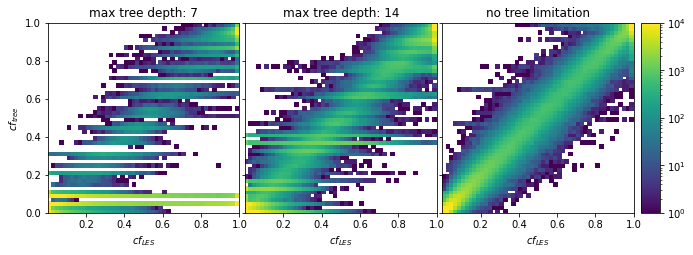

In [22]:

#dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_025deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
    goal_var   = 'cl_l'
    input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

    max_depth_in_vec = [3,6,9]
    max_depth_in_vec = [6,9,0]
    max_depth_in_vec = [7,14,0]
    fig = func_plot_cfhist_mult(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=50)


number of nodes in tree: 245
number samples in training set: 14400
number of nodes in tree: 5261
number samples in training set: 14400
number of nodes in tree: 12279
number samples in training set: 14400


/home/igor/anaconda3/envs/MSC_env/lib/python3.7/site-packages/ipykernel_launcher.py:114: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.
/home/igor/anaconda3/envs/MSC_env/lib/python3.7/site-packages/ipykernel_launcher.py:119: MatplotlibDeprecationWarning: Passing parameters norm and vmin/vmax simultaneously is deprecated since 3.3 and will become an error two minor releases later. Please pass vmin/vmax directly to the norm when creating it.


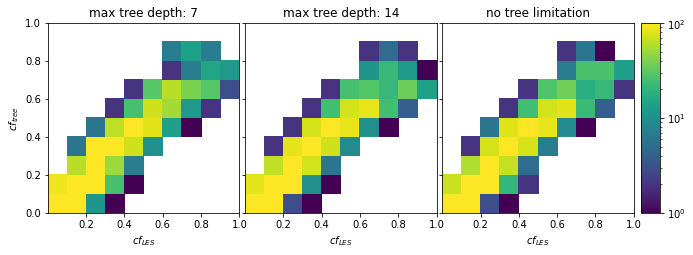

In [12]:
#dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
dat_string = file_dir+'ncr_pdf_douze_1deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_025deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

max_depth_in_vec = [3,6,9]
max_depth_in_vec = [6,9,0]
max_depth_in_vec = [7,14,0]
fig = func_plot_cfhist_mult(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=10)


In [28]:
func_plot_cfhist_mult

<function __main__.func_plot_cfhist_mult(dat_string, goal_var, input_var, train_fraction=0.6, rel_flag=0, max_depth_in_vec=[7, 14, 0], N_bin=100, learning_flag=0)>

/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


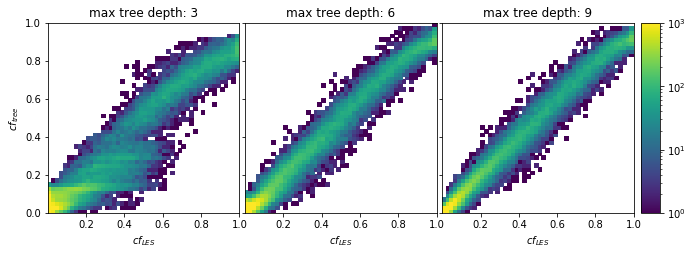

In [222]:
file_dir = '/work/HDCP2_paper/Schland/'
dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
dat_string = file_dir+'ncr_pdf_douze_1deg.nc'
dat_string = file_dir+'ncr_pdf_douze_025deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

max_depth_in_vec = [3,6,9]
#max_depth_in_vec = [6,9,0]
#max_depth_in_vec = [7,14,21]
#max_depth_in_vec = [1,2,3]
fig = func_plot_cfhist_mult_gradboost(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=50)


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


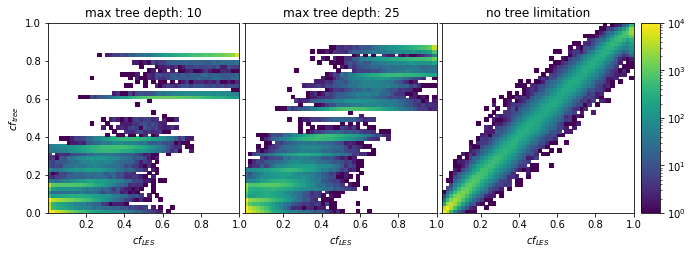

In [241]:
file_dir = '/work/HDCP2_paper/Schland/'
dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_05deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_025deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

max_depth_in_vec = [3,6,9]
#max_depth_in_vec = [6,9,0]
max_depth_in_vec = [7,14,21]
max_depth_in_vec = [10,25,0]
fig = func_plot_cfhist_mult_ranforest(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=50)


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


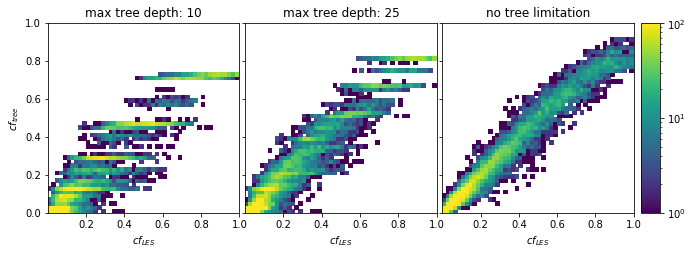

In [242]:
file_dir = '/work/HDCP2_paper/Schland/'
#dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
dat_string = file_dir+'ncr_pdf_douze_05deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_025deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

max_depth_in_vec = [3,6,9]
#max_depth_in_vec = [6,9,0]
max_depth_in_vec = [7,14,21]
max_depth_in_vec = [10,25,0]
fig = func_plot_cfhist_mult_ranforest(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=50)


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


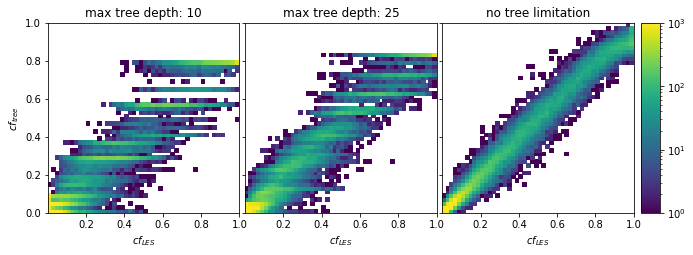

In [274]:
file_dir = '/work/HDCP2_paper/Schland/'
#dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_05deg.nc'
dat_string = file_dir+'ncr_pdf_douze_025deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

max_depth_in_vec = [3,6,9]
#max_depth_in_vec = [6,9,0]
max_depth_in_vec = [7,14,21]
max_depth_in_vec = [10,25,0]
#fig = func_plot_cfhist_mult_ranforest(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=50)
fig = func_plot_cfhist_mult(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=50,learning_flag=2)


In [275]:
fig.savefig('/home/pgriewank/OC/papers/2019-tree/first_figs/forest_tree_depth.pdf',bbox_inches='tight')

/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


number of nodes in tree: 125
number samples in training set: 230400
number of nodes in tree: 971
number samples in training set: 230400
number of nodes in tree: 97491
number samples in training set: 230400


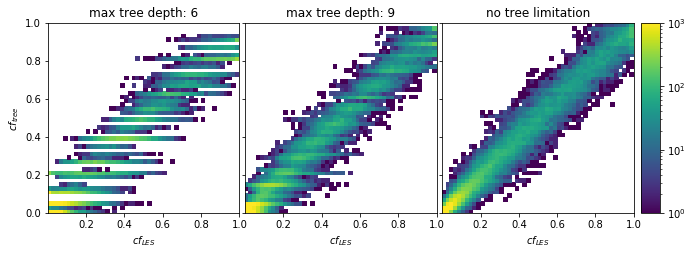

In [245]:
file_dir = '/work/HDCP2_paper/Schland/'
#dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_05deg.nc'
dat_string = file_dir+'ncr_pdf_douze_025deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

max_depth_in_vec = [3,6,9]
max_depth_in_vec = [6,9,0]
#max_depth_in_vec = [7,14,21]
#max_depth_in_vec = [10,25,0]
fig = func_plot_cfhist_mult(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=50)


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


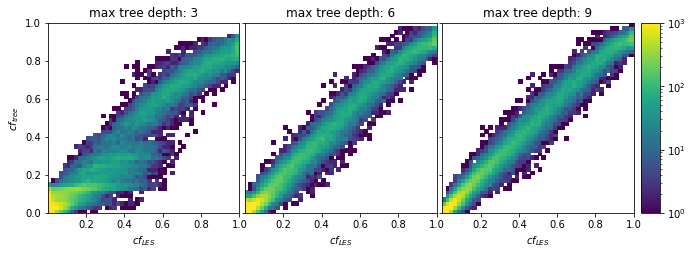

In [252]:
file_dir = '/work/HDCP2_paper/Schland/'
#dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_05deg.nc'
dat_string = file_dir+'ncr_pdf_douze_025deg.nc'
#dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

max_depth_in_vec = [3,6,9]
#max_depth_in_vec = [6,9,0]
#max_depth_in_vec = [7,14,21]
#max_depth_in_vec = [10,25,0]
fig = func_plot_cfhist_mult(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=50,learning_flag=1)


In [149]:
fig.savefig('/home/pgriewank/OC/papers/2019-tree/first_figs/tree_depth.pdf',bbox_inches='tight')

/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)
/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6894: RuntimeWarning: invalid value encountered in greater
  h[h > cmax] = None
/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/matplotlib/colors.py:1028: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


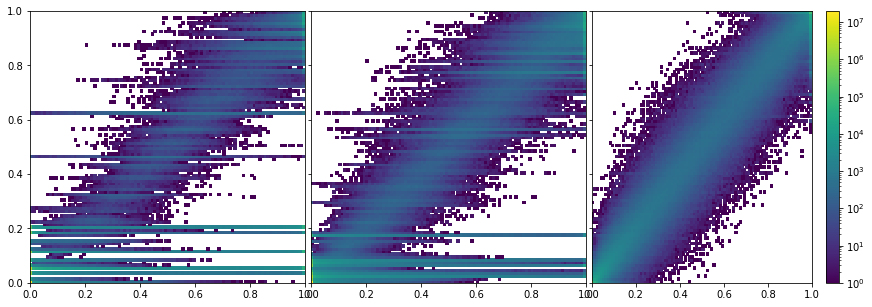

In [51]:
file_dir = '/work/HDCP2_paper/Schland/'
dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
dat_string = file_dir+'ncr_pdf_douze_00625deg.nc'
dat_string = file_dir+'ncr_pdf_douze_003125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

max_depth_in_vec = [9,15,0]
fig = func_plot_cfhist_mult(dat_string,goal_var,input_var,rel_flag=2,max_depth_in_vec=max_depth_in_vec,N_bin=100)


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


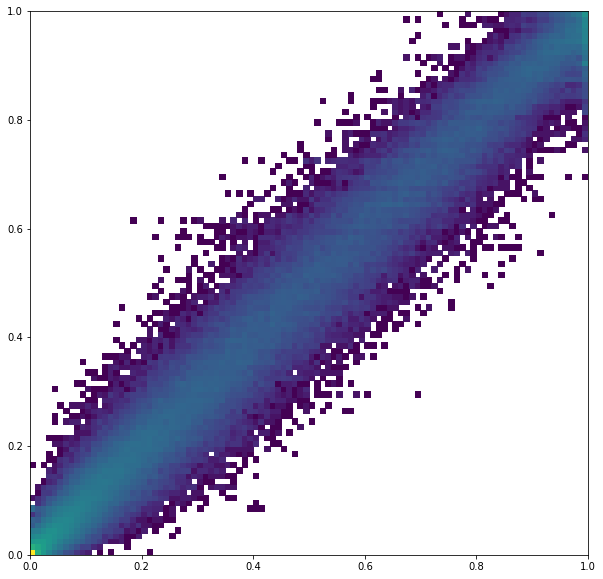

In [5]:
file_dir = '/work/HDCP2_paper/Schland/'
dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
fig = func_plot_cfhist(dat_string,goal_var,input_var,rel_flag=2)


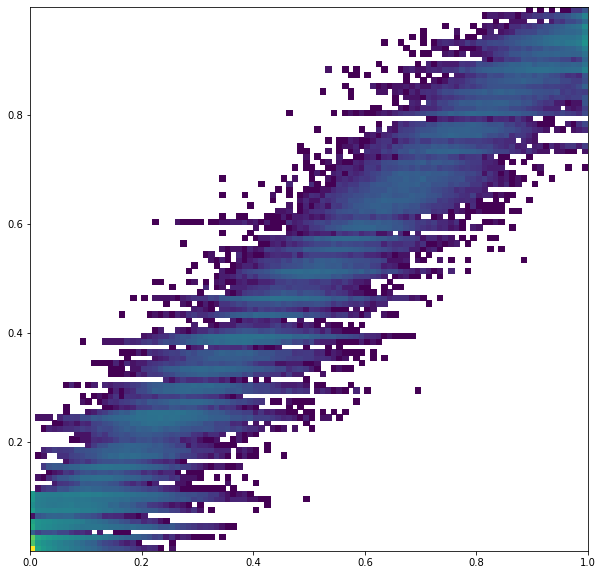

In [14]:
dat_string = file_dir+'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
fig = func_plot_cfhist(dat_string,goal_var,input_var,rel_flag=2,max_depth_in=10)


/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


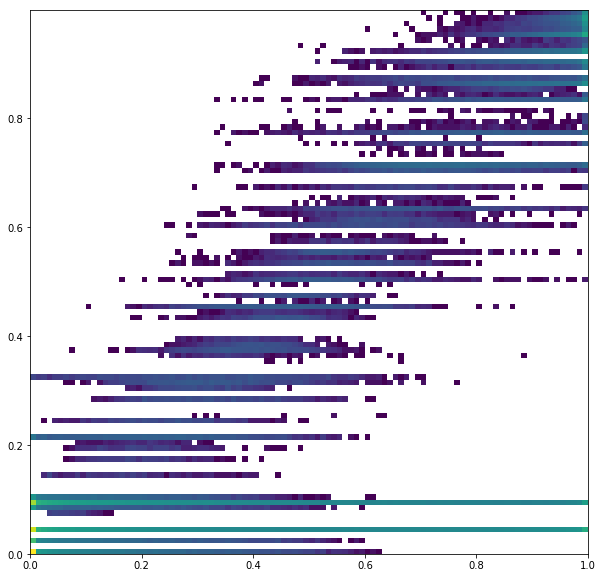

In [169]:
dat_string = 'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
fig = func_plot_cfhist(dat_string,goal_var,input_var,rel_flag=2,max_depth_in=7)


/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


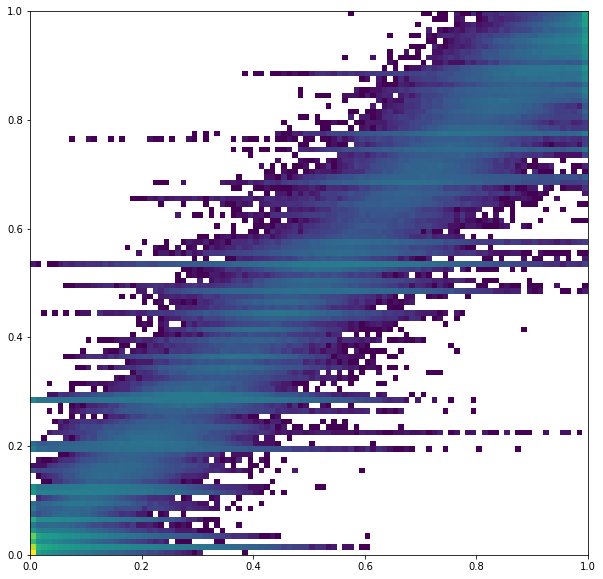

In [168]:
dat_string = 'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
fig = func_plot_cfhist(dat_string,goal_var,input_var,rel_flag=2,max_depth_in=15)


/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


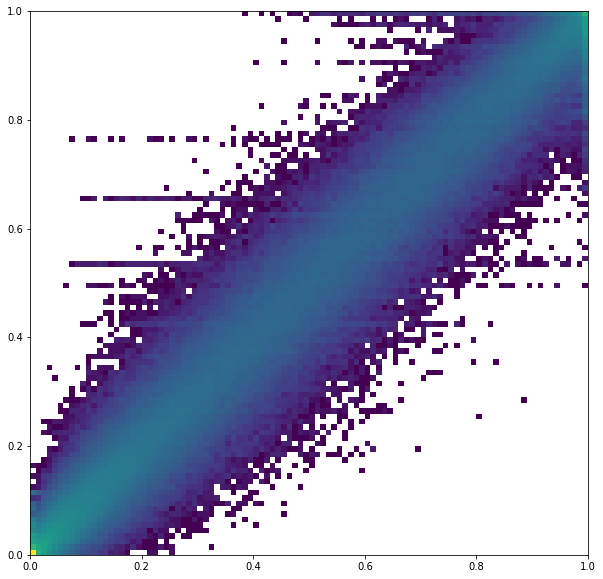

In [161]:
dat_string = 'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
fig = func_plot_cfhist(dat_string,goal_var,input_var,rel_flag=2)


# So, the plan

Make function that is given the following
percentile: how much of data used for training

file: string of the file to load

goal_str : string which indicates what is y

input_str: list of all the input input strings that go into X

Function:

I: loads data from file, ravels it, schuffles it, sorts it into training and testing set

II: make regression tree

III: 

In [94]:
def func_treeregression(dat_string,goal_var,input_var,train_fraction=0.6,rel_flag=0,std_flag=0,max_depth_in=0,learning_flag=0):
    #Applies a decisiontreeregressor and returns the relative ME, RMSE, and the input variables sorted by importance and a vector of their importance
    #rel_flag: Since relative humidity is not part of the douze data it is calculated here and added according to this flat
    #rel_flag = 1, adds rel_hum
    #rel_flag = 2, adds qvlm_sqsm (qt-sat)
    #std_flag = 1, adds var_l/(qt-sat)
    
    #Loading data
    data= Dataset(dat_string)
    y = data.variables[goal_var][:].ravel()
    
    X=np.zeros([0,len(y)])
    
    for input in input_var:
        x_temp = data.variables[input][:].ravel()
        X = np.vstack([X,x_temp])
    
    input_var_tmp = input_var.copy()
    #print(input_var_tmp)

    #Add relative humidity
    if rel_flag==1:
        rel_sat =  data.variables['qvlm'][:].ravel()/ data.variables['qsm'][:].ravel()
        X = np.vstack([X,rel_sat])
        
        input_var_tmp.append('rel_sat')
    if rel_flag==2:
        qvl_qs =  data.variables['qvlm'][:].ravel()- data.variables['qsm'][:].ravel()
        X = np.vstack([X,qvl_qs])
            
        input_var_tmp.append('qvl_qs')
        
    if std_flag==1:
        var = data.variables['var_l'][:].ravel()
        #print(var.shape)
        std = (var)**0.5
        #print(std.shape)
        qt_qs = data.variables['qtm'][:].ravel()-data.variables['qsm'][:].ravel()
        #print(qt_qs.shape)
        
        std_rel =  std/qt_qs
        
        X = np.vstack([X,std_rel])
            
        input_var_tmp.append('std_rel')
        
    #print(input_var_tmp)
        
    n_e = int(len(y)*train_fraction)
    
    p = np.random.permutation(len(y))

    y_shuf = y[p]
    X_shuf = X[:,p]

    y_train =y[n_e:]
    y_eval  =y[:n_e]

    X_train =X[:,n_e:]
    X_eval  =X[:,:n_e]

    X_train = X_train.transpose()
    X_eval = X_eval.transpose()
        
    #Now we set up the tree
    if learning_flag == 0:
        if max_depth_in == 0:
            max_depth_in = None
        regr_1 = tree.DecisionTreeRegressor(max_depth=max_depth_in)
    if learning_flag == 1:
        if max_depth_in == 0:
            max_depth_in = None
        regr_1 = ensemble.GradientBoostingRegressor(max_depth=max_depth_in)
    if learning_flag == 2:
        if max_depth_in == 0:
            regr_1 = ensemble.RandomForestRegressor()
        else:
            regr_1 = ensemble.RandomForestRegressor(n_estimators=max_depth_in,max_leaf_nodes=max_depth_in)

    
    #Now we train the tree
    regr_1.fit(X_train, y_train)
    
    #Now the prediction magic happens
    y_pred = regr_1.predict(X_eval)

    #y_eval =  regr_1.predict(X_)
    # print('Best parameters set found on development set:\n')
    # print(regr_1.best_params_)
    
    #now trying sort the input list by importance of inputs
    feat_imp = regr_1.feature_importances_
    import_inds = feat_imp.argsort()
    #print(import_inds)
    #print(import_inds[::-1])
    #print(feat_imp[import_inds[::-1]])
    #print(input_var[import_inds[::-1]])
    sorted_inputs = []
    #print(input_var_tmp)
        
    for i in range(len(input_var_tmp)):
        #print(len(input_var_tmp)-i-1)
        sorted_inputs.append(input_var_tmp[import_inds[len(input_var_tmp)-i-1]])

    #sorted_inputs = input_var[import_inds[::-1]]
    sorted_import = feat_imp[import_inds[::-1]]
    #print("Feature importance:\n")
    #print(input_var)
    #print(feat_imp)
    #print(sorted_import)
    #print(sorted_inputs)
    #print(sorted_import)

    ME   = np.mean(y_pred-y_eval)/np.mean(y_eval)
    RMSE = np.mean((y_eval-y_pred)**2.)**0.5/np.mean(y_eval)
    
    
    print('relative ME and RMSE of Eval in %')
    print(str(ME*100)[:3],str(RMSE*100)[:5])

    
    
    return ME, RMSE, sorted_inputs, sorted_import, feat_imp

1
relative ME and RMSE of Eval in %
12. 126.9
05
relative ME and RMSE of Eval in %
8.6 126.6
025
relative ME and RMSE of Eval in %
5.1 126.2


Text(0.5, 0, 'slice size in km')

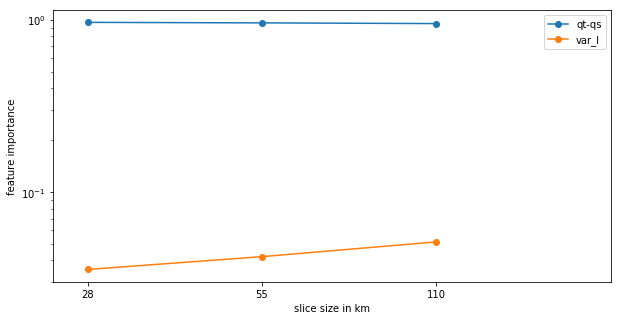

In [95]:
#Lets see what the random forest gives if it only has the rel_hum
res_stri = [ '1','05','025']#,'0125']#,'00625']#,'003125']
res_name = [ '110','55','28']#,'14']#,'7']#,'3.5']
goal_var = 'cl_l'
#Best to arrange them roughly by increasing importance 
input_var  =  ['var_l']
file_dir = '/work/HDCP2_paper/Schland/'

extra_n = 1


#Need to add plus 1 or plus two if rel_flag or std_flag are being used
feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+extra_n])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:]     = \
    func_treeregression(dat_string,goal_var,input_var,std_flag=0,rel_flag=1,learning_flag=0)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
#input_string.append('std_rel')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


1
relative ME and RMSE of Eval in %
5.9 88.28
05
relative ME and RMSE of Eval in %
3.4 84.90
025
relative ME and RMSE of Eval in %
2.2 81.10
0125
relative ME and RMSE of Eval in %
1.2 77.42
00625
relative ME and RMSE of Eval in %
1.0 76.25


Text(0.5, 0, 'slice size in km')

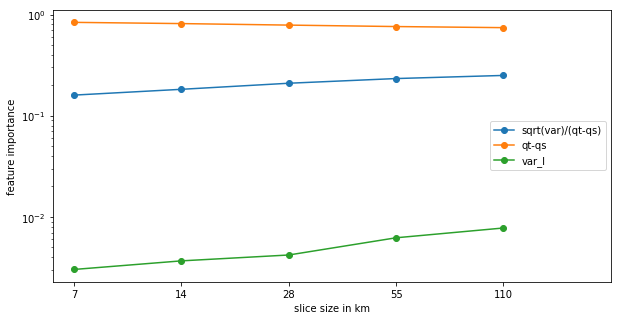

In [103]:
#Lets see what the random forest gives if it only has the rel_hum
res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
goal_var = 'cl_l'
#Best to arrange them roughly by increasing importance 
input_var  =  ['var_l']
file_dir = '/work/HDCP2_paper/Schland/'

extra_n = 2


#Need to add plus 1 or plus two if rel_flag or std_flag are being used
feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+extra_n])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:]     = \
    func_treeregression(dat_string,goal_var,input_var,std_flag=1,rel_flag=1,learning_flag=0)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
input_string.append('sqrt(var)/(qt-qs)')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


1
relative ME and RMSE of Eval in %
-7. 141.5
05
relative ME and RMSE of Eval in %
-2. 131.8
025
relative ME and RMSE of Eval in %
1.4 123.7
0125
relative ME and RMSE of Eval in %
1.8 120.3
00625
relative ME and RMSE of Eval in %
-16 303.9


Text(0.5, 0, 'slice size in km')

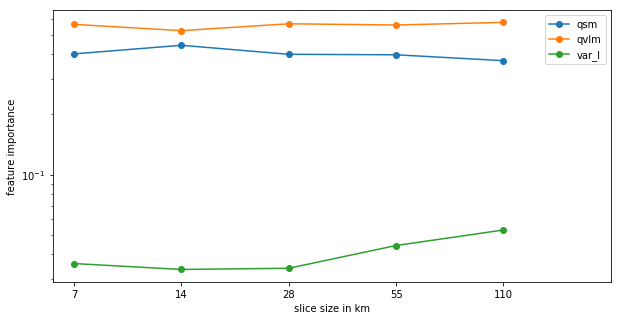

In [107]:
#Lets see what the random forest gives if it only has the rel_hum
res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
goal_var = 'cl_l'
#Best to arrange them roughly by increasing importance 
input_var  =  ['var_l','qvlm','qsm']
file_dir = '/work/HDCP2_paper/Schland/'

extra_n = 0


#Need to add plus 1 or plus two if rel_flag or std_flag are being used
feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+extra_n])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:]     = \
    func_treeregression(dat_string,goal_var,input_var,std_flag=0,rel_flag=0,learning_flag=0)#,max_depth_in=3)
    #func_treeregression(dat_string,goal_var,input_var,std_flag=1,rel_flag=1,learning_flag=0)#,max_depth_in=3)
    

#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
#input_string.append('qt-qs')
#input_string.append('sqrt(var)/(qt-qs)')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


In [108]:
fig.savefig('/home/pgriewank/OC/papers/2019-tree/first_figs/importance_raw.pdf',bbox_inches='tight')

# Ok, lets get serious. Plot contribution of all variables as well as errors over domain size


In [152]:
#first of all we have some annoying strings and variables to define
res_stri = [ '1','05','025','0125','00625','003125']
res_name = [ '110','55','28','14','7','3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['var_l','qsm','tm','qtm','var_t','pm','skew_l','qlm']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub = np.zeros([len(res_stri)])
RMSE_sub = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    print(input_var)
    ME_sub[i], RMSE_sub[i], sorted_inputs, sorted_import, feat_imp_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2)#,max_depth_in=3)


    

['var_l', 'qsm', 'tm', 'qtm', 'var_t', 'pm', 'skew_l', 'qlm']
relative ME and RMSE of Eval in %
6.5 65.10
['var_l', 'qsm', 'tm', 'qtm', 'var_t', 'pm', 'skew_l', 'qlm']


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
3.4 57.28
['var_l', 'qsm', 'tm', 'qtm', 'var_t', 'pm', 'skew_l', 'qlm']
relative ME and RMSE of Eval in %
1.9 48.68
['var_l', 'qsm', 'tm', 'qtm', 'var_t', 'pm', 'skew_l', 'qlm']
relative ME and RMSE of Eval in %
1.0 43.08
['var_l', 'qsm', 'tm', 'qtm', 'var_t', 'pm', 'skew_l', 'qlm']
relative ME and RMSE of Eval in %
0.6 44.58
['var_l', 'qsm', 'tm', 'qtm', 'var_t', 'pm', 'skew_l', 'qlm']
relative ME and RMSE of Eval in %
0.4 49.66


In [277]:
#Now only resolved things

res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['qsm','tm','qtm','pm']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)])#+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(rest_st)
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=0)#,max_depth_in=3)


    

['qsm', 'tm', 'qtm', 'pm']
relative ME and RMSE of Eval in %
22. 210.1
['qsm', 'tm', 'qtm', 'pm']
relative ME and RMSE of Eval in %
0.7 175.0
['qsm', 'tm', 'qtm', 'pm']
relative ME and RMSE of Eval in %
6.3 187.6
['qsm', 'tm', 'qtm', 'pm']
relative ME and RMSE of Eval in %
-4. 163.7
['qsm', 'tm', 'qtm', 'pm']
relative ME and RMSE of Eval in %
-0. 172.4


Text(0.5, 0, 'slice size in km')

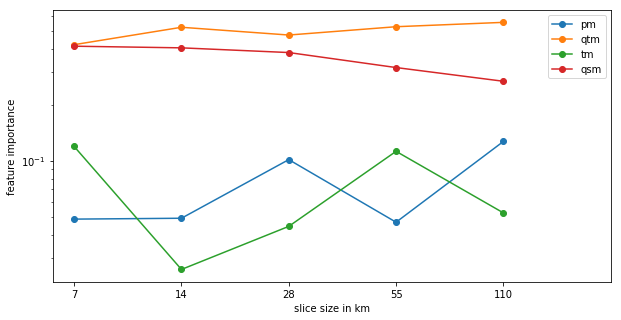

In [281]:
#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
#input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


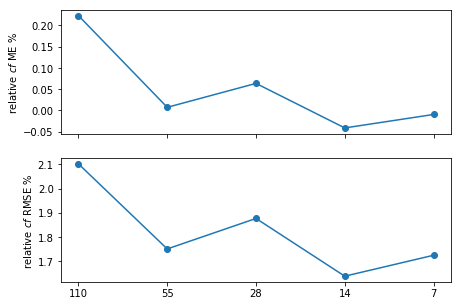

In [285]:
#Second plot for errors
fig,axes=plt.subplots(2,1,figsize=(7,5),sharex=True)

x_axis= np.arange(0,len(res_stri))

axes[0].plot(x_axis,ME_sub_resolved,'o-')
axes[1].plot(x_axis,RMSE_sub_resolved,'o-')
axes[0].set_ylabel('relative $cf$ ME %')
axes[1].set_ylabel('relative $cf$ RMSE %')
#axes[0].set_ylim(0.0,max(ME_sub_resolved)*1.1)

    
#ax.set_yscale("log")
bla = axes[1].set_xticks(x_axis)
bla = axes[1].set_xticklabels(res_name)
#axes[1].set_xlim(x_axis[0]-0.2,x_axis[-1]+0.5)
#ax.legend()    
    

In [289]:
#Now only resolved things, but with relative humidity

res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['qsm','tm','qtm','pm']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri)
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=1)#,max_depth_in=3)


    

['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-9. 124.5
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-12 131.2
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-9. 134.5
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-6. 138.8
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-5. 145.0


Text(0.5, 0, 'slice size in km')

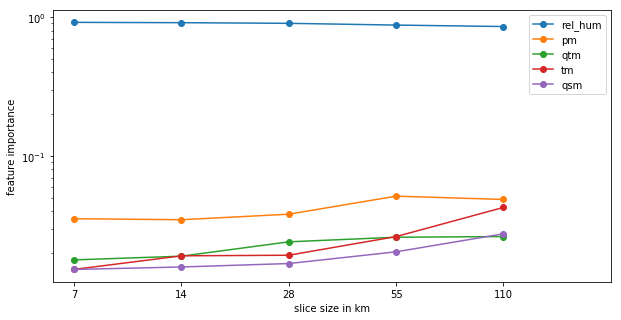

In [290]:
#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('rel_hum')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


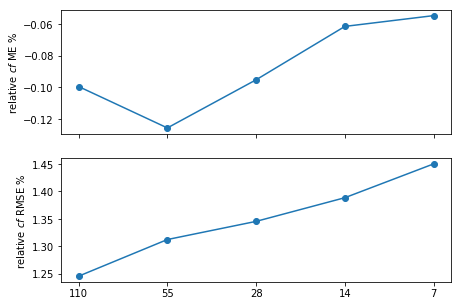

In [291]:
#Second plot for errors
fig,axes=plt.subplots(2,1,figsize=(7,5),sharex=True)

x_axis= np.arange(0,len(res_stri))

axes[0].plot(x_axis,ME_sub_resolved,'o-')
axes[1].plot(x_axis,RMSE_sub_resolved,'o-')
axes[0].set_ylabel('relative $cf$ ME %')
axes[1].set_ylabel('relative $cf$ RMSE %')
#axes[0].set_ylim(0.0,max(ME_sub_resolved)*1.1)

    
#ax.set_yscale("log")
bla = axes[1].set_xticks(x_axis)
bla = axes[1].set_xticklabels(res_name)
#axes[1].set_xlim(x_axis[0]-0.2,x_axis[-1]+0.5)
#ax.legend()    
    

['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
6.2 106.4
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
8.7 116.7
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
5.7 124.2
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
5.6 125.8
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
6.6 130.2


Text(0.5, 0, 'slice size in km')

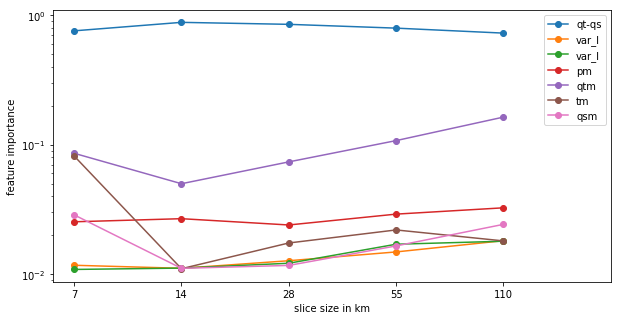

In [297]:
#Now only resolved things, but with relative humidity

res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['qsm','tm','qtm','pm','var_l','var_l']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri)
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')

    

['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
6.1 59.45
['1', '05', '025', '0125', '00625']


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
3.1 56.05
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
1.6 48.87
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
1.1 44.98
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
0.5 44.39


Text(0.5, 0, 'slice size in km')

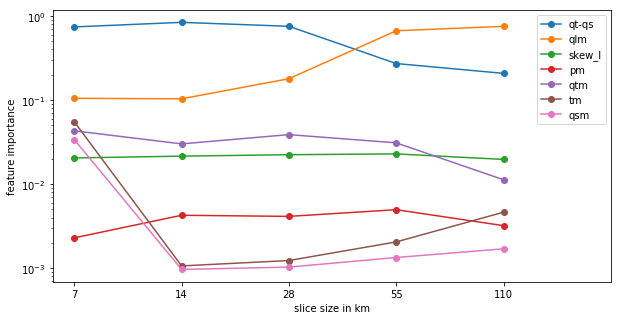

In [295]:
#Now the equivalent to zsl

res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['qsm','tm','qtm','pm','skew_l','qlm']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri)
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-6. 60.49
['1', '05', '025', '0125', '00625']


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
-3. 55.84
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-1. 48.85
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-1. 45.42
['1', '05', '025', '0125', '00625']
relative ME and RMSE of Eval in %
-0. 43.92


Text(0.5, 0, 'slice size in km')

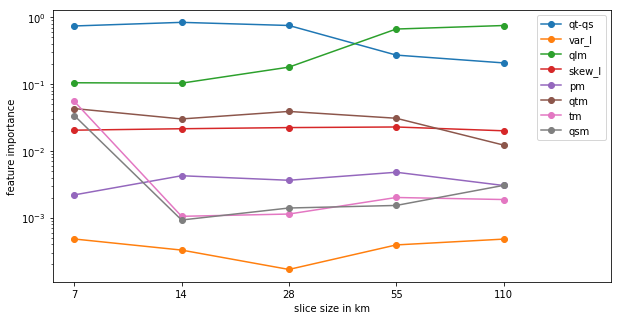

In [298]:
#Now the equivalent to zff

res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['qsm','tm','qtm','pm','skew_l','qlm','var_l']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri)
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


1
relative ME and RMSE of Eval in %
-1. 172.2
05
relative ME and RMSE of Eval in %
-8. 197.2
025
relative ME and RMSE of Eval in %
-4. 206.3
0125
relative ME and RMSE of Eval in %
-5. 189.9
00625
relative ME and RMSE of Eval in %
-5. 175.1


Text(0.5, 0, 'slice size in km')

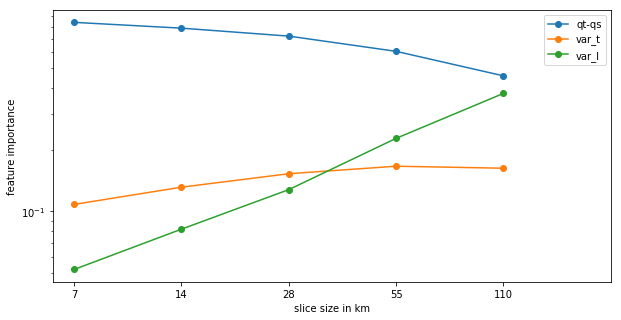

In [300]:
#Why the fuck doesn't var_l do anything? 

res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['var_l','var_t']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


1
relative ME and RMSE of Eval in %
-1. 172.2
05
relative ME and RMSE of Eval in %
-8. 197.2
025
relative ME and RMSE of Eval in %
-4. 206.3
0125
relative ME and RMSE of Eval in %
-5. 189.9
00625
relative ME and RMSE of Eval in %
-5. 175.1


Text(0.5, 0, 'slice size in km')

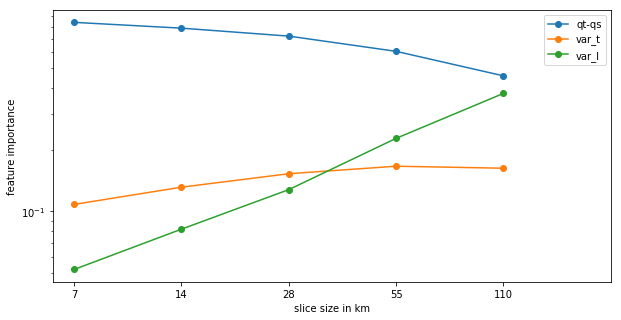

In [300]:
#Why the fuck doesn't var_l do anything? 

res_stri = [ '1','05','025','0125','00625']#,'003125']
res_name = [ '110','55','28','14','7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['var_l','var_t']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


1


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
-0. 90.76
05


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
2.7 86.07
025


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
2.7 86.91
0125


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
2.2 87.10


Text(0.5, 0, 'slice size in km')

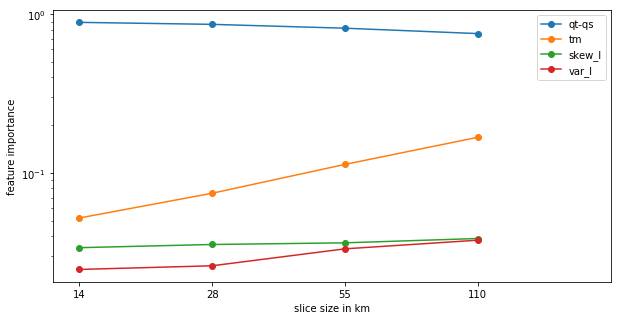

In [310]:
#Lets see what we can get from the random forest plus variance and skewness
res_stri = [ '1','05','025','0125']#,'00625']#,'003125']
res_name = [ '110','55','28','14']#,'7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['var_l','skew_l','tm']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,learning_flag=2)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


1
relative ME and RMSE of Eval in %
10. 102.1
05
relative ME and RMSE of Eval in %
11. 107.2
025
relative ME and RMSE of Eval in %
10. 112.3
0125
relative ME and RMSE of Eval in %
7.7 115.2


Text(0.5, 0, 'slice size in km')

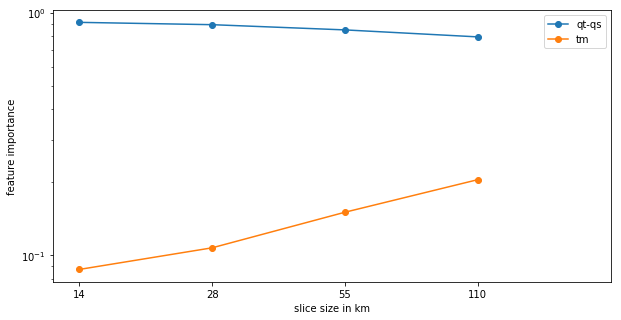

In [309]:
#Lets see what the random forest gives if it only has the rel_hum
res_stri = [ '1','05','025','0125']#,'00625']#,'003125']
res_name = [ '110','55','28','14']#,'7']#,'3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['tm']
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,learning_flag=2)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


1
relative ME and RMSE of Eval in %
-2. 233.1
05
relative ME and RMSE of Eval in %
5.8 193.9
025
relative ME and RMSE of Eval in %
9.1 177.0
0125
relative ME and RMSE of Eval in %
5.4 164.4


/home/pgriewank/local_programs/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3507: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=1.0, top=1.0
  self.set_ylim(upper, lower, auto=None)


Text(0.5, 0, 'slice size in km')

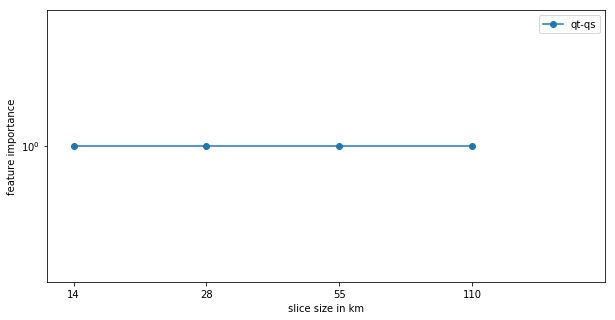

In [34]:
#Lets see what the random forest gives if it only has the rel_hum
res_stri = [ '1','05','025','0125']#,'00625']#,'003125']
res_name = [ '110','55','28','14']#,'7']#,'3.5']
goal_var = 'cl_l'
#Best to arrange them roughly by increasing importance 
input_var  =  []
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:] = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,learning_flag=2)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


In [39]:
#Lets see what the random forest gives if it only has the rel_hum
res_stri = [ '1','05','025','0125']#,'00625']#,'003125']
res_name = [ '110','55','28','14']#,'7']#,'3.5']
goal_var = 'cl_l'
#Best to arrange them roughly by increasing importance 
input_var  =  []
file_dir = '/work/HDCP2_paper/Schland/'


feat_imp_resolved_matrix = np.zeros([len(res_stri),len(input_var)+1])
ME_sub_resolved = np.zeros([len(res_stri)])
RMSE_sub_resolved = np.zeros([len(res_stri)])

for i in range(len(res_stri)):
#for res in res_stri:
    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    #print(input_var)
    print(res_stri[i])
    ME_sub_resolved[i], RMSE_sub_resolved[i], sorted_inputs, sorted_import, feat_imp_resolved_matrix[i,:]     = \
    func_treeregression(dat_string,goal_var,input_var,std_flag=1,rel_flag=1,learning_flag=0)#,max_depth_in=3)


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_resolved_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


1
(36000,)
relative ME and RMSE of Eval in %
3.2 93.00


ValueError: could not broadcast input array from shape (2) into shape (1)

In [38]:
np.sqrt(np.zeros(10))

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [7]:
np.zeros([10,0])

array([], shape=(10, 0), dtype=float64)

In [280]:
print(x_axis)
print(feat_imp_matrix[:,i])

[5 4 3 2 1]
[0.01192257 0.03097528 0.03721797 0.02785094 0.04230395 0.06694809]


In [167]:
#saving the errors as a pickly before I fuck it up
import pickle
with open('tree_errors', 'wb') as f:
    pickle.dump([ME_sub, RMSE_sub], f)


In [166]:
#flipping ME because of a coding error, should be corrected in the function now
ME_sub=-ME_sub

Text(0.5, 0, 'slice size in km')

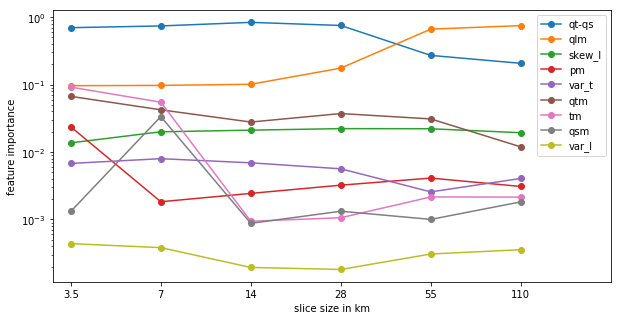

In [272]:

res_stri = [ '1','05','025','0125','00625','003125']
res_name = [ '110','55','28','14','7','3.5']
#Best to arrange them roughly by increasing importance 
input_var  =  ['var_l','qsm','tm','qtm','var_t','pm','skew_l','qlm']
file_dir = '/work/HDCP2_paper/Schland/'


#Now one plot for individual contributions
fig,ax=plt.subplots(figsize=(10,5))

input_string = input_var.copy()
input_string.append('qt-qs')
x_axis= np.arange(len(res_stri),0,-1)
for i in range(len(input_string)-1,-1,-1):
    plt.plot(x_axis,feat_imp_matrix[:,i],'o-',label=input_string[i])
    
ax.set_yscale("log")
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+1.0)
#ax.set_xlim(x_axis[0]-0.2,x_axis[-1]+1.0)
ax.legend()   
ax.set_ylabel('feature importance')
ax.set_xlabel('slice size in km')


    


In [273]:
fig.savefig('/home/pgriewank/OC/papers/2019-tree/first_figs/feat_importance.pdf',bbox_inches='tight')

(-0.2, 5.5)

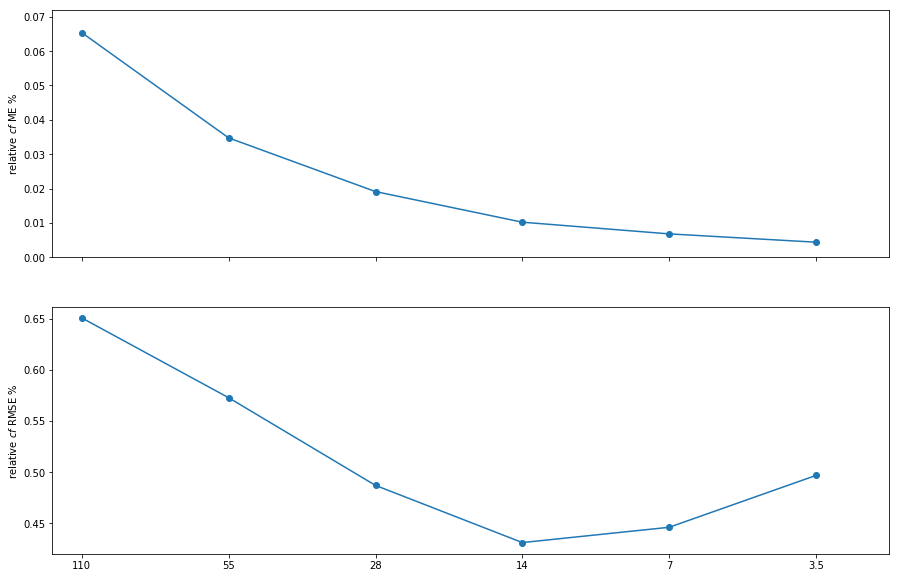

In [163]:
#Second plot for errors
fig,axes=plt.subplots(2,1,figsize=(15,10),sharex=True)

x_axis= np.arange(0,len(res_stri))

axes[0].plot(x_axis,ME_sub,'o-')
axes[1].plot(x_axis,RMSE_sub,'o-')
axes[0].set_ylabel('relative $cf$ ME %')
axes[1].set_ylabel('relative $cf$ RMSE %')
axes[0].set_ylim(0.0,max(ME_sub)*1.1)

    
#ax.set_yscale("log")
bla = axes[1].set_xticks(x_axis)
bla = axes[1].set_xticklabels(res_name)
axes[1].set_xlim(x_axis[0]-0.2,x_axis[-1]+0.5)
#ax.legend()    
    

In [185]:
#now with the added parametrization errors
#first of all we have some annoying strings and variables to define
res_stri = [ '1','05','025','0125','00625','003125']
res_name = [ '110','55','28','14','7','3.5']
#Best to arrange them roughly by increasing importance 
para_name  =  ['cl_zsl','cl_p00','cl_3sl']
file_dir = '/work/HDCP2_paper/Schland/'

ME_sub_para = np.zeros([len(para_name),len(res_stri)])
RMSE_sub_para = np.zeros([len(para_name),len(res_stri)])

#for res in res_stri:
for i in range(len(res_stri)):
    print(res_stri[i])

    dat_string = file_dir+'ncr_pdf_douze_'+res_stri[i]+'deg.nc'
    f_in = Dataset(dat_string)
        
    cl_l =  f_in.variables['cl_l'][:].ravel()
    for p in range(len(para_name)):
        print(para_name[p])
        cl_tmp =  f_in.variables[para_name[p]][:].ravel()

        ME_sub_para[p,i] = np.mean(cl_tmp-cl_l)/np.mean(cl_l)
        RMSE_sub_para[p,i] = np.sqrt(np.mean((cl_tmp-cl_l)**2.))/np.mean(cl_l)
        

1
cl_zsl
cl_p00
cl_3sl
05
cl_zsl
cl_p00
cl_3sl
025
cl_zsl
cl_p00
cl_3sl
0125
cl_zsl
cl_p00
cl_3sl
00625
cl_zsl
cl_p00
cl_3sl
003125
cl_zsl
cl_p00
cl_3sl


cl_zsl
cl_p00
cl_3sl
cl_zsl
cl_p00
cl_3sl


Text(0.5, 0, 'slice size in km')

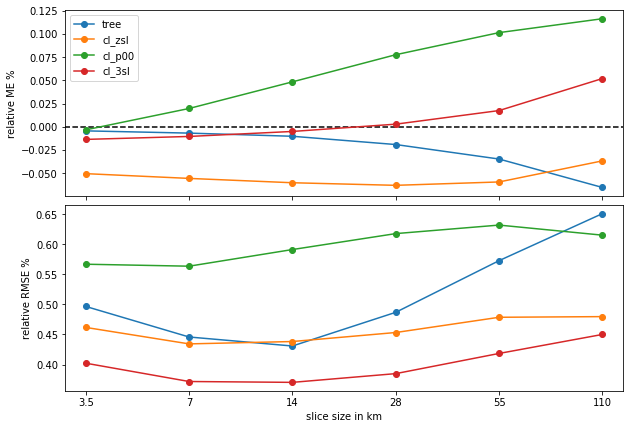

In [270]:
fig,axes = plt.subplots(2,1,figsize=(10,7),sharex=True)
x_axis= np.arange(len(res_stri),0,-1)

ax=axes[0]
ax.plot(x_axis,ME_sub,'o-',label='tree')
ax.set_ylabel('relative ME %')
ax.hlines(0,x_axis[0]+1,x_axis[-1]-1,'k',linestyles='--')

for p in range(len(para_name)):
    print(para_name[p])
    ax.plot(x_axis,ME_sub_para[p,:],'o-',label=para_name[p])
    


plt.subplots_adjust(wspace=0.05, hspace=0.05)

ax=axes[1]
ax.plot(x_axis,RMSE_sub,'o-',label='tree')
ax.set_ylabel('relative RMSE %')
for p in range(len(para_name)):
    print(para_name[p])
    ax.plot(x_axis,RMSE_sub_para[p,:],'o-',label=para_name[p])

ax.set_xlim(x_axis[-1]-0.2,x_axis[0]+0.2)


axes[0].legend(loc='upper left')    

bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(res_name)
ax.set_xlabel('slice size in km')



In [271]:
fig.savefig('/home/pgriewank/OC/papers/2019-tree/first_figs/errors_sub.pdf',bbox_inches='tight')

In [190]:
np.arange(10,0,-1)

array([10,  9,  8,  7,  6,  5,  4,  3,  2,  1])

In [178]:
# Something is fucked up with the RMSE errors, the tree errors are way to fucking high

In [142]:
ME_matrix

array([[0.05853199, 0.05853199, 0.05853199, 0.05853199, 0.05853199,
        0.05853199, 0.05853199, 0.05853199, 0.05853199],
       [0.03380112, 0.03380112, 0.03380112, 0.03380112, 0.03380112,
        0.03380112, 0.03380112, 0.03380112, 0.03380112],
       [0.01919239, 0.01919239, 0.01919239, 0.01919239, 0.01919239,
        0.01919239, 0.01919239, 0.01919239, 0.01919239],
       [0.01084163, 0.01084163, 0.01084163, 0.01084163, 0.01084163,
        0.01084163, 0.01084163, 0.01084163, 0.01084163],
       [0.00710915, 0.00710915, 0.00710915, 0.00710915, 0.00710915,
        0.00710915, 0.00710915, 0.00710915, 0.00710915]])

['1', '05', '025', 'wtf']

/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval
0.020184846357103704 0.5538149323896481


Text(0.5,1,'_0125deg ME: 2.01 %, RMSE: 55.38 %')

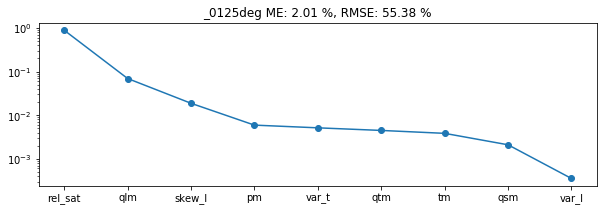

In [58]:
dat_string = 'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=1)#,max_depth_in=3)
fig,ax=plt.subplots(figsize=(10,3))
x_axis= np.arange(0,len(sorted_inputs))
plt.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')

/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
12. 164.8
relative ME and RMSE of Eval in %
2.2 63.26


KeyError: 'rel_sat'

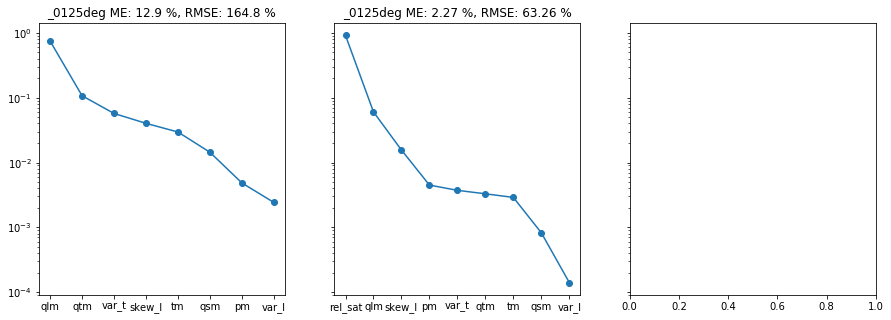

In [85]:
max_d = None
max_d = 10


dat_string = 'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

fig,axes=plt.subplots(1,3,figsize=(15,5),sharey=True)

ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=0,max_depth_in=max_d)

ax=axes[0]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')



ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=1,max_depth_in=max_d)


ax=axes[1]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')


ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,max_depth_in=max_d)

ax=axes[2]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')



relative ME and RMSE of Eval in %
-6. 136.8
relative ME and RMSE of Eval in %
2.5 60.83


/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
1.5 43.03
relative ME and RMSE of Eval in %
1.5 42.78
relative ME and RMSE of Eval in %
1.1 43.01


Text(0.5,1,'_0125deg ME: 1.11 %, RMSE: 43.01 %')

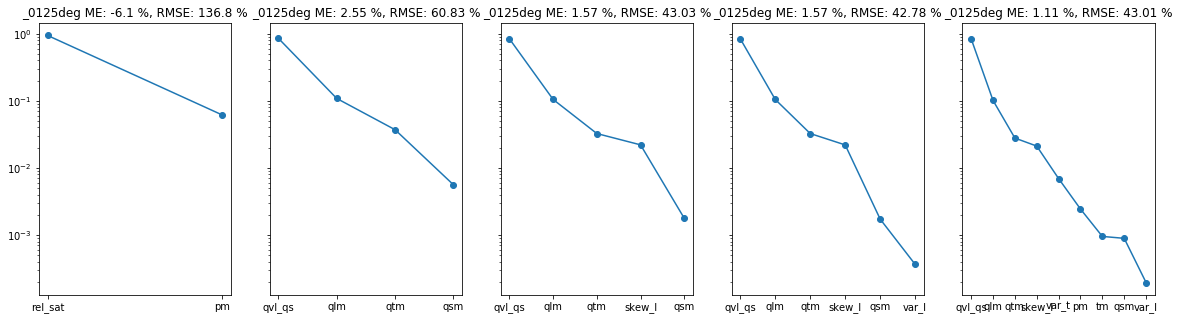

In [88]:
#Now I vary the input according to the rel hum, skew 0, and zsl , and zff, and finally all
max_d = 10
max_d = None
percent = 0.60


dat_string = 'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['pm']

fig,axes=plt.subplots(1,5,figsize=(20,5),sharey=True)

ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=1,train_fraction=percent,max_depth_in=max_d)

ax=axes[0]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')



input_var  = ['qlm','qsm','qtm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,train_fraction=percent,max_depth_in=max_d)


ax=axes[1]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')


input_var  = ['qsm','qlm','skew_l','qtm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,train_fraction=percent,max_depth_in=max_d)

ax=axes[2]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')


input_var  = ['qsm','qtm','skew_l','var_l','qlm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,train_fraction=percent,max_depth_in=max_d)


ax=axes[3]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')



input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,train_fraction=percent,max_depth_in=max_d)

ax=axes[4]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')




/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
16. 138.1
relative ME and RMSE of Eval in %
3.6 68.10
relative ME and RMSE of Eval in %
1.6 63.46


Text(0.5,1,'_0125deg ME: 1.61 %, RMSE: 63.46 %')

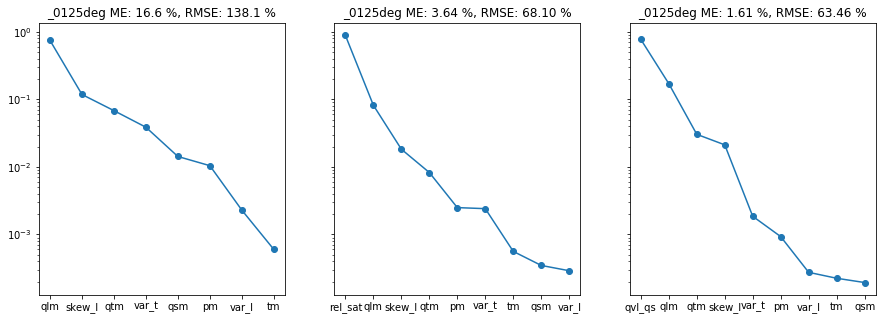

In [79]:
max_d = 10
percent = 0.90

max_d = None
percent = 0.90


dat_string = 'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

fig,axes=plt.subplots(1,3,figsize=(15,5),sharey=True)

ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=0,train_fraction=percent,max_depth_in=max_d)

ax=axes[0]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')



ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=1,train_fraction=percent,max_depth_in=max_d)


ax=axes[1]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')


ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,train_fraction=percent,max_depth_in=max_d)

ax=axes[2]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')




/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval in %
7.5 102.3
relative ME and RMSE of Eval in %
1.5 52.93
relative ME and RMSE of Eval in %
0.7 44.54


Text(0.5,1,'00625deg ME: 0.73 %, RMSE: 44.54 %')

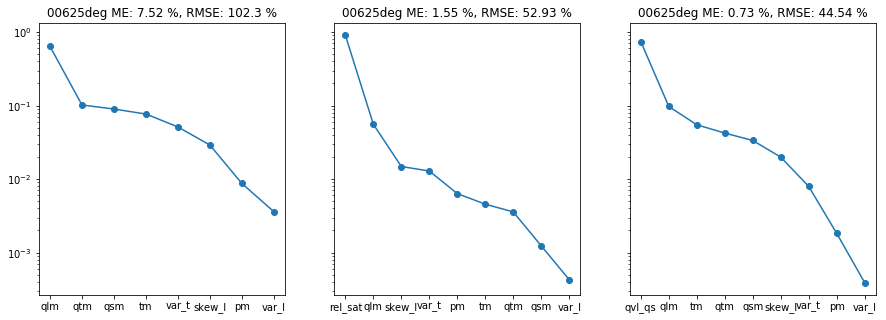

In [84]:
#Now for thig big 00625 file

max_d = 10
percent = 0.90

max_d = None
percent = 0.60


dat_string = 'ncr_pdf_douze_00625deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']

fig,axes=plt.subplots(1,3,figsize=(15,5),sharey=True)

ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=0,train_fraction=percent,max_depth_in=max_d)

ax=axes[0]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')



input_var  = ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=1,train_fraction=percent,max_depth_in=max_d)


ax=axes[1]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')


input_var  = ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=2,train_fraction=percent,max_depth_in=max_d)

ax=axes[2]
x_axis= np.arange(0,len(sorted_inputs))
ax.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')



/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval
0.011237625044816553 0.4475292927649553


Text(0.5,1,'_0125deg ME: 1.12 %, RMSE: 44.75 %')

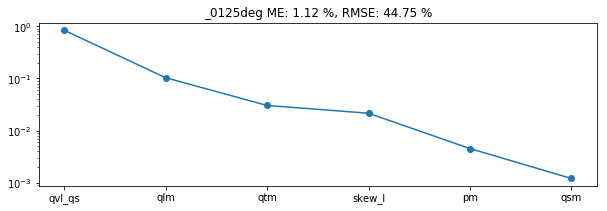

In [64]:
dat_string = 'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','pm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=2)#,max_depth_in=3)
fig,ax=plt.subplots(figsize=(10,3))
x_axis= np.arange(0,len(sorted_inputs))
plt.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')

/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


relative ME and RMSE of Eval
0.020184846357103704 0.5538149323896481


Text(0.5,1,'_0125deg ME: 2.01 %, RMSE: 55.38 %')

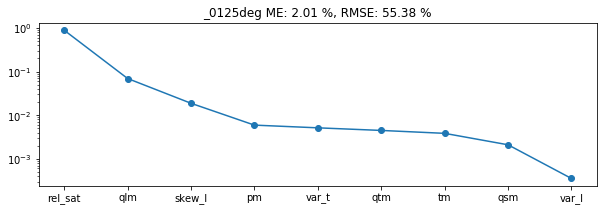

In [58]:
dat_string = 'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['qsm','qtm','qlm','skew_l','var_l','var_t','tm','pm']
ME, RMSE, sorted_inputs, sorted_import = func_treeregression(dat_string,goal_var,input_var,rel_flag=1)#,max_depth_in=3)
fig,ax=plt.subplots(figsize=(10,3))
x_axis= np.arange(0,len(sorted_inputs))
plt.plot(x_axis,sorted_import,'o-')
bla = ax.set_xticks(x_axis)
bla = ax.set_xticklabels(sorted_inputs)
ax.set_yscale("log")
ax.set_title(dat_string[-11:-3]+' ME: ' + str(ME*100)[:4]+' %, RMSE: '+str(RMSE*100)[:5] +' %')

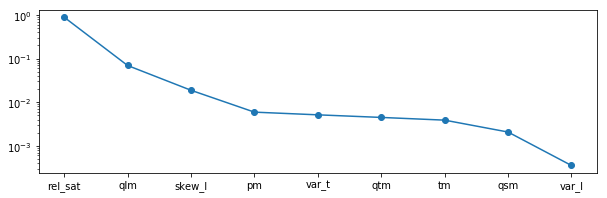

In [27]:
dat_string = 'ncr_pdf_douze_0125deg.nc'
goal_var   = 'cl_l'
input_var  =  ['pm']
func_treeregression(dat_string,goal_var,input_var,rel_flag=1)


Feature importance:

['pm', 'rel_sat']
[0.06116223 0.93883777]
[0.93883777 0.06116223]
['rel_sat', 'pm']
relative ME and RMSE of Eval
-0.06259450738058434 1.3694051546894752


(-0.06259450738058434,
 1.3694051546894752,
 ['rel_sat', 'pm'],
 array([0.93883777, 0.06116223]))

# rel humidity comparison for Kwinton

In [61]:
data= Dataset(file_dir+'ncr_pdf_douze_0125deg.nc')

In [62]:
cl_l = data.variables['cl_l'][:].ravel()
cl_zsl = data.variables['cl_zsl'][:].ravel()


In [63]:
sat = data.variables['qsm'][:].ravel()
rvl = data.variables['qvlm'][:].ravel()
rl = data.variables['qlm'][:].ravel()
skew_l = data.variables['skew_l'][:].ravel()
var_l = data.variables['var_l'][:].ravel()
var_t = data.variables['var_t'][:].ravel()
tm = data.variables['tm'][:].ravel()
pm = data.variables['pm'][:].ravel()


In [64]:
rel_sat = rvl/sat


In [29]:
y=cl_l[cl_l>0]
X = np.zeros([len(y),1])
X[:,0]=rel_sat[cl_l>0]


In [28]:
np.zeros([4,1])

array([[0.],
       [0.],
       [0.],
       [0.]])

In [29]:
sat_range = np.linspace(0.5,1.2,101)

dsat = (1.2-0.5)/101/2
sat_x = np.linspace(0.5+dsat/2,1.2-dsat/2,100)
sat_ave = np.zeros(100)
for i in range(100):
    sat_ave[i] = np.mean(cl_l[abs(rel_sat-sat_range[i])<dsat ])

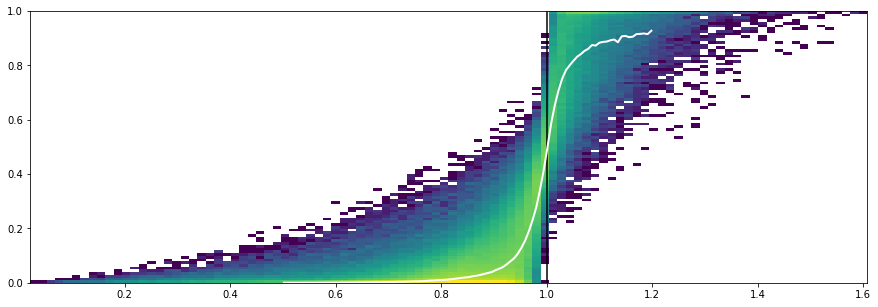

In [36]:
fig = plt.figure(figsize=(15,5))
bla = plt.hist2d(rel_sat[cl_l>0],cl_l[cl_l>0],bins=100, norm=LogNorm())
#bla = plt.hist2d(rel_sat,cl_l,bins=100, norm=LogNorm())
bla = plt.plot(sat_x,sat_ave,color='w',linewidth=2)
plt.vlines(1,0,1,'k')

# trying to figure out why the liquid variance plays no role

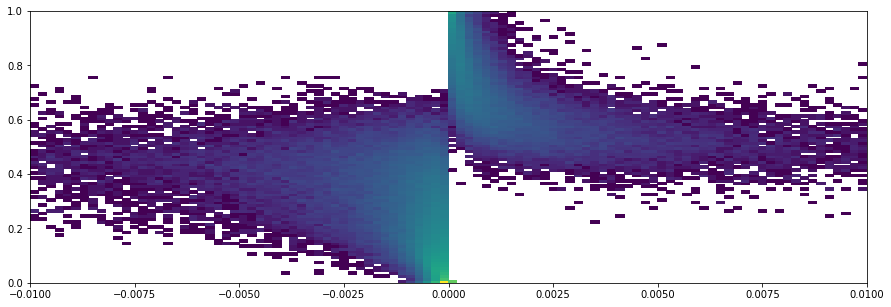

In [100]:
fig = plt.figure(figsize=(15,5))
test_var = np.sqrt(var_l)/(rvl-sat)
test_var = var_l/(rvl-sat)
bla = plt.hist2d(test_var,cl_l,bins=100, norm=LogNorm(),range=[[-0.01,0.01],[0,1]])
#bla = plt.hist2d(rel_sat,cl_l,bins=100, norm=LogNorm())
#bla = plt.plot(sat_x,sat_ave,color='w',linewidth=2)
#plt.vlines(1,0,1,'k')

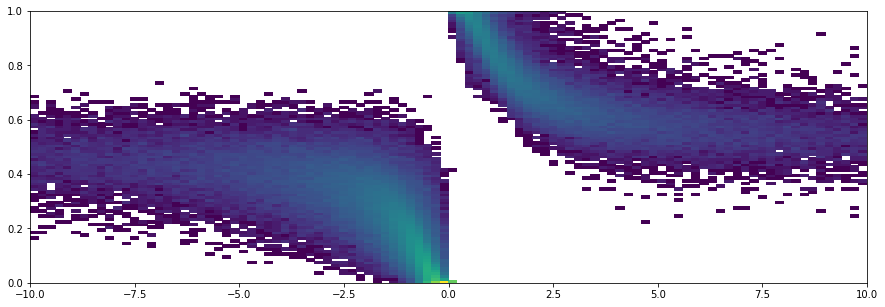

In [101]:
fig = plt.figure(figsize=(15,5))
test_var = np.sqrt(var_l)/(rvl-sat)
bla = plt.hist2d(test_var,cl_l,bins=100, norm=LogNorm(),range=[[-10,10],[0,1]])
#bla = plt.hist2d(rel_sat,cl_l,bins=100, norm=LogNorm())
#bla = plt.plot(sat_x,sat_ave,color='w',linewidth=2)
#plt.vlines(1,0,1,'k')

# First tree experiments

In [100]:
y=cl_l[cl_l>0]

X=np.vstack([rel_sat[cl_l>0],rvl[cl_l>0]])
X = X.transpose()
X.shape


(373524, 2)

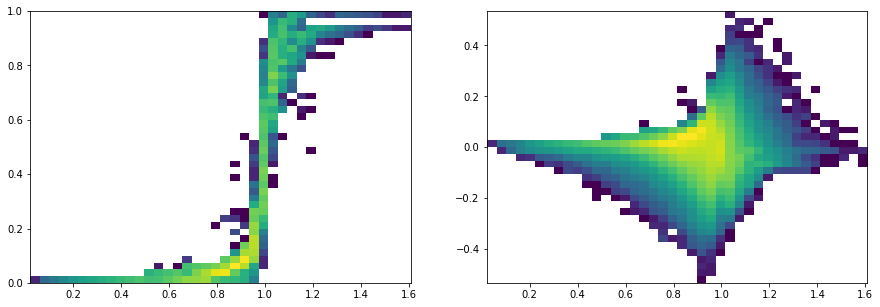

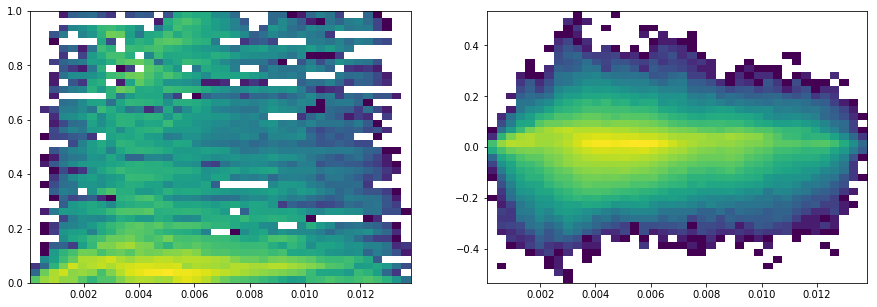

In [101]:
#clf = tree.DecisionTreeRegressor()
regr_1 = tree.DecisionTreeRegressor(max_depth=10)
regr_1.fit(X, y)
y_1 = regr_1.predict(X)


fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,0],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,0],y_1-y,bins=40, norm=LogNorm())

fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,1],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,1],y_1-y,bins=40, norm=LogNorm())



# now lets try multiple inputs with all data

In [103]:
y=cl_l

X=np.vstack([rel_sat,rvl,rl])
X = X.transpose()
X.shape


(2304000, 3)

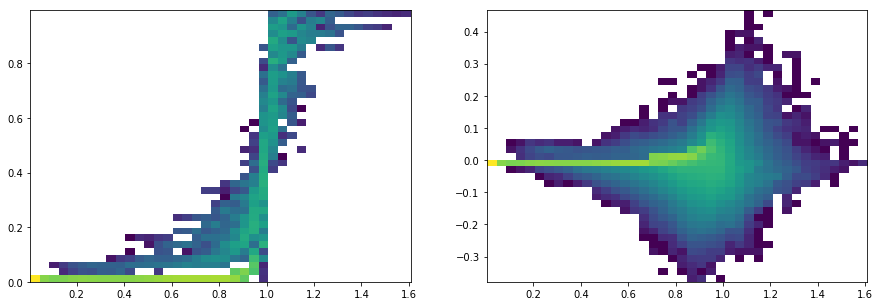

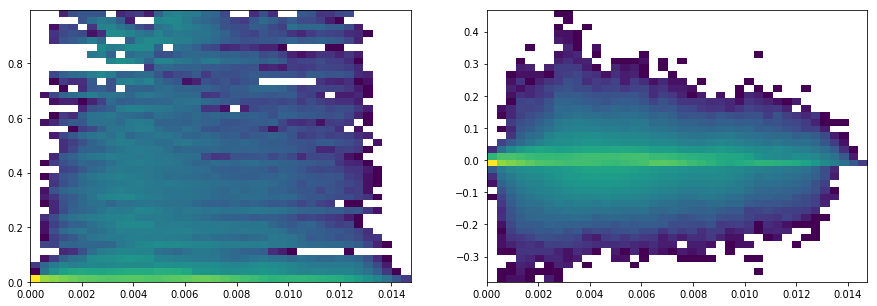

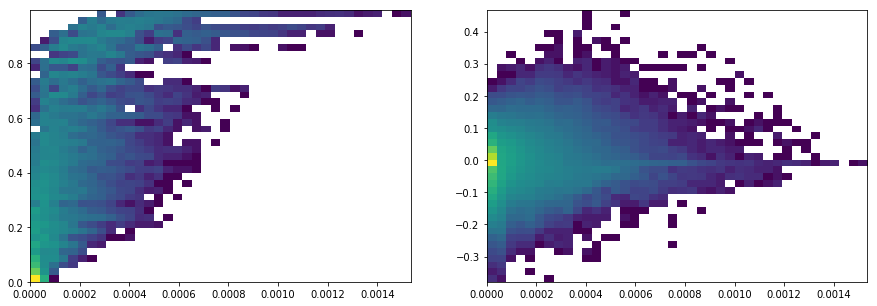

In [104]:
#clf = tree.DecisionTreeRegressor()
regr_1 = tree.DecisionTreeRegressor(max_depth=10)
regr_1.fit(X, y)
y_1 = regr_1.predict(X)


fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,0],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,0],y_1-y,bins=40, norm=LogNorm())

fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,1],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,1],y_1-y,bins=40, norm=LogNorm())

fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,2],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,2],y_1-y,bins=40, norm=LogNorm())



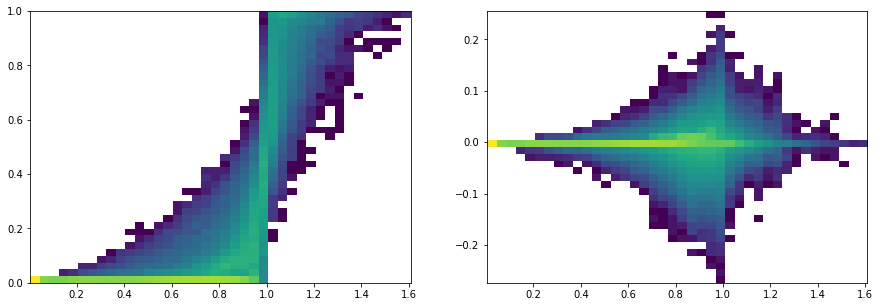

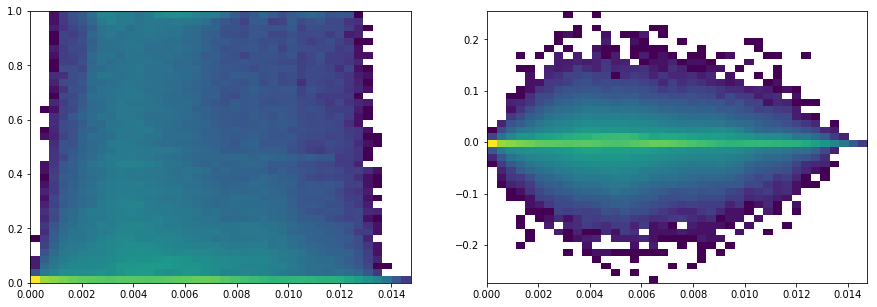

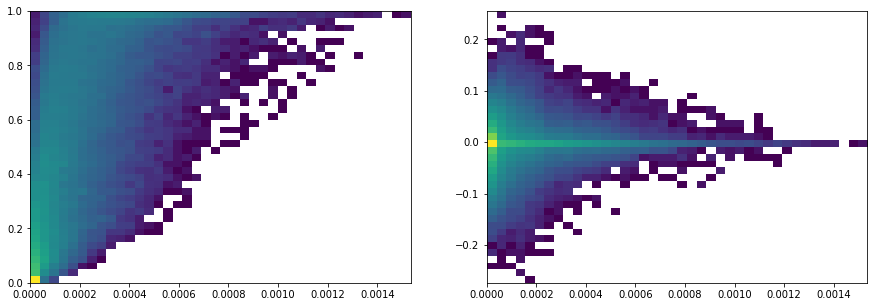

In [105]:
#clf = tree.DecisionTreeRegressor()
regr_1 = tree.DecisionTreeRegressor(max_depth=20)
regr_1.fit(X, y)
y_1 = regr_1.predict(X)


fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,0],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,0],y_1-y,bins=40, norm=LogNorm())

fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,1],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,1],y_1-y,bins=40, norm=LogNorm())

fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,2],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,2],y_1-y,bins=40, norm=LogNorm())



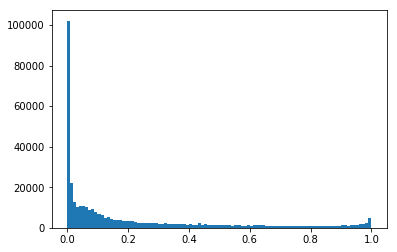

In [110]:
bla=plt.hist(y_1[y>0.0],100)

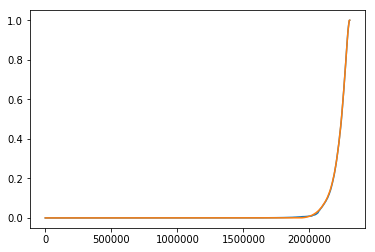

In [113]:
plt.plot(np.sort(y_1))
plt.plot(np.sort(y))

# Simple tree, but plot contributions

In [89]:
y = cl_l
X = np.vstack([rel_sat,rvl,rl])
X = np.vstack([rvl,rl])
X = np.vstack([rel_sat,rvl,rl,var_t,var_l,skew_l,tm,pm])

n_e = 1000000
p = np.random.permutation(len(y))

y_shuf = y[p]
X_shuf = X[:,p]

y_train =y[n_e:]
y_eval  =y[:n_e]

X_train =X[:,n_e:]
X_eval  =X[:,:n_e]

X_train = X_train.transpose()
X_eval = X_eval.transpose()


In [80]:
regr_1 = tree.DecisionTreeRegressor(max_depth=None)
regr_1.fit(X_train, y_train)
y_pred = regr_1.predict(X_eval)

#y_eval =  regr_1.predict(X_)
# print('Best parameters set found on development set:\n')
# print(regr_1.best_params_)
print("Feature importance:\n")
print(regr_1.feature_importances_)

print('relative ME and RMSE of Eval')
print(np.mean(y_eval-y_pred)/np.mean(y_eval),(np.mean((y_eval-y_pred)**2.))**0.5/np.mean(y_eval))


Feature importance:

[0.19559808 0.80440192]
relative ME and RMSE of Eval
0.373546636078117 2.463986424804605


In [90]:
regr_1 = tree.DecisionTreeRegressor(max_depth=None)
regr_1.fit(X_train, y_train)
y_pred = regr_1.predict(X_eval)

#y_eval =  regr_1.predict(X_)
# print('Best parameters set found on development set:\n')
# print(regr_1.best_params_)
print("Feature importance:\n")
print(100*regr_1.feature_importances_)

print('relative ME and RMSE of Eval')
print(np.mean(y_eval-y_pred)/np.mean(y_eval),(np.mean((y_eval-y_pred)**2.))**0.5/np.mean(y_eval))


/home/pgriewank/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:32: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims)


Feature importance:

[9.08685636e+01 1.06264424e+00 5.30860901e+00 5.54976792e-01
 3.37494375e-02 1.55752885e+00 3.98425265e-01 2.15502831e-01]
relative ME and RMSE of Eval
0.03445191512808624 0.5647979020494308


In [78]:
#clf = ensemble.GradientBoostingRegressor()

#clf.fit(X_train, y_train)
y_pred = clf.predict(X_eval)

#y_eval =  regr_1.predict(X_)
# print('Best parameters set found on development set:\n')
# print(regr_1.best_params_)
print("Feature importance:\n")
print(clf.feature_importances_)

print('relative ME and RMSE of Eval')
print(np.mean(y_eval-y_pred)/np.mean(y_eval),(np.mean((y_eval-y_pred)**2.))**0.5/np.mean(y_eval))


Feature importance:

[0.55688761 0.23183677 0.21127562]
relative ME and RMSE of Eval
-0.030902400556475404 1.0494633578414216


In [55]:
y_zsl = cl_zsl[p]
y_zsl = cl_zsl[:n_e]
print('relative ME and RMSE of cl_zsl')
print(np.mean(y_eval-y_zsl)/np.mean(y_eval),(np.mean((y_eval-y_zsl)**2.))**0.5/np.mean(y_eval))


relative ME and RMSE of cl_zsl
0.08524517385346035 1.2183887309979446


In [68]:
y_zsl = cl_zsl[p]
y_zsl = cl_zsl[:n_e]
print('relative ME and RMSE of cl_zsl')
print(np.mean(cl_zsl-cl_l)/np.mean(cl_l),(np.mean((cl_zsl-cl_l)**2.))**0.5/np.mean(cl_l))


relative ME and RMSE of cl_zsl
-0.06027260343945234 0.43827204371150996


In [72]:
#n_e = 1000000
y_zsl = cl_zsl[p]
y_zsl = y_zsl[:n_e]
y_l = cl_l[p]
y_l = y_l[:n_e]

print('relative ME and RMSE of cl_zsl')
print(np.mean(y_zsl-y_l)/np.mean(y_l),(np.mean((y_zsl-y_l)**2.))**0.5/np.mean(y_l))


relative ME and RMSE of cl_zsl
-0.06050682216769354 0.4397460356044522


In [ ]:

fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,0],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,0],y_1-y,bins=40, norm=LogNorm())

fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,1],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,1],y_1-y,bins=40, norm=LogNorm())

fig,axes = plt.subplots(1,2,figsize=(15,5))
bla = axes[0].hist2d(X[:,2],y_1,bins=40, norm=LogNorm())
bla = axes[1].hist2d(X[:,2],y_1-y,bins=40, norm=LogNorm())


